In [2]:
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba.typed import List
import time
from numba.typed import Dict
from numba.core import types
import numba

In [14]:
@jit(nopython=True)
def initialize_graph(n_list:numba.typed.typedlist.List,groups:numba.typed.typedlist.List, initial_nodes:int):
    """
    Create inital regular graph with mm nodes, one group and aa inter group connections

    Parameters:   n_list: list of nodes of the graph. This list represents nodes in the following convention => 
    
    |con_node1, con_node2,.....,con_nodeAA,con_nodeAA+1, con_nodeAA+2,.....,con_nodeBB,(aa+bb)*obs_node||....|

    groups: list of lists containg the information about the contents and degree of nodes in groups

    Returns: rfe_df: RFE ranking of features 

    :names: names of the variables which should be dropped
    """
    #create initial regular graph
    for ii in np.arange(initial_nodes):
        #each node has #initial_nodes-1 connections
        for jj in np.arange(initial_nodes-1):
            n_list.append(ii)

    #create group zero with initial nodes
    groups.append(n_list.copy())
    
    return n_list, groups

In [174]:
@jit(nopython=True)
def proportional_attach(node_list,groups,group_dict, mm,aa,bb,p,indexes, iterator, num_of_nodes, group_counter):

    #initial length of an node_list, lets us get proportial attachment on the basis of the old list for each of the new added nodes
    length_init=len(node_list)
        #until you reach number of nodes which should be added
        
    #decide whether we want to append this point to existing group or create new group
    if np.random.random()>p:
        print("hello1")
        #create connections inside the group
        
        groups.append(List.empty_list(types.int32))
        group_counter=len(groups)
        created_nodes=List.empty_list(types.int32)
        for node in np.arange(num_of_nodes):
            # indexes=List()
            #number of added node
            added_node=len(group_dict)
            created_nodes.append(added_node)
            group_dict[added_node]=group_counter
            add_global_connections(node_list,group_dict,groups,bb,added_node,group_counter,length_init)
            
        # groups.append(new_group)
        
        #create connections inside group
        init_group_length=len(groups[group_counter])
        for added_node in created_nodes:
            indexes=List()
            # added_node=mm+node+iterator
            for ii in np.arange(0,aa):

                ind=np.random.randint(0,init_group_length)
                indexes.append(ind)
            #append selected connections to the list 
            for indx in indexes:
                val=groups[group_counter][indx]
                node_list.append(val)
                groups[group_counter].append(val)
            for indx in indexes:
                groups[group_counter].append(added_node)
                node_list.append(added_node)
    else:
            print("hello2")
            created_nodes=List.empty_list(types.int32)
            #needs checking
            for node in np.arange(num_of_nodes):
                
                indexes=List()
                #number of added node
                added_node=mm+node+iterator
                added_node=len(group_dict)
                created_nodes.append(added_node)
                #initial node to which our new node will attach and connect to this group
                initial_index=np.random.randint(0,length_init)

                #attach this new node to this group
                group_number=group_dict[node_list[initial_index]]
                group_dict[added_node]=group_number
                
                for ii in np.arange(0,aa-1):
                    ind=np.random.randint(0,len(groups[group_number]))
                    indexes.append(ind)
                #append selected connections to the list 
                #append initial connection to the list
                node_list.append(node_list[initial_index])
                groups[group_number].append(node_list[initial_index])
                for indx in indexes:
                    val=groups[group_number][indx]
                    node_list.append(val)
                    groups[group_number].append(val)
                for indx in indexes:
                    val=added_node
                    groups[group_number].append(val)
                    node_list.append(added_node)
                node_list.append(added_node)
                
            for added_node in created_nodes:
                add_global_connections(node_list,group_dict,groups,bb,added_node,group_number,length_init)
                    

    
    return group_counter

In [175]:
@jit(nopython=True)
def add_global_connections(n_list, gr_dict, gr_list, bb, new_node_id, group_id, initial_length):
    indexes=List()
    
    for ii in np.arange(0,bb):
        ind=np.random.randint(0,initial_length)
        indexes.append(ind)

        #append selected connections to the list 
    for indx in indexes:
        node_id=n_list[indx]
        n_list.append(node_id)
        gr_list[gr_dict[node_id]].append(node_id)
    for indx in indexes:
        n_list.append(new_node_id)
        gr_list[group_id].append(new_node_id)


In [123]:
new_group=List.empty_list(types.int32)
groups.append(new_group)

In [124]:
groups

ListType[ListType[int32]]([[0, 0, 1, 1, 2, 2, ...], [, ...], ...])

In [176]:
m=3
initial_nodes=m
# n_nodes=10**8
n_nodes=10**6
n_nodes=100
group_dict = Dict.empty(
    key_type=types.int64,
    value_type=types.int64,
)
for ii in np.arange(initial_nodes):
    group_dict[ii]=0
# a=m-1
a=2
b=2
# node_list=np.full((m-1)*m+n_nodes*(a+b)*2,-1, dtype= np.int32)
node_list=List.empty_list(types.int32)
list_size=len(node_list)
groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))
node_list,groups=initialize_graph(node_list,groups, initial_nodes,a,b)


0
0
1
1
2
2


In [178]:
node_list[6:30]

ListType[int32]([0, 2, 3, 3, 2, 2, 4, 4, 2, 4, 5, 5, 0, 2, 6, 6, 1, 0, 7, 7, 0, 0, 3, 3, ...])

In [177]:
ii=0
num_of_nodes=2*a+1
indexes=np.full(a+b,-1)
group_counter=0
p=1
for n_number in tqdm(np.arange(m,n_nodes+m,num_of_nodes)):
    group_counter=proportional_attach(node_list,groups,group_dict,m,a,b,p,indexes,ii,num_of_nodes, group_counter)
    ii+=num_of_nodes

100%|██████████| 20/20 [00:02<00:00,  8.62it/s]

hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2
hello2


In [140]:
node_list[:30]

ListType[int32]([0, 0, 1, 1, 2, 2, 1, 0, 3, 3, 2, 0, 4, 4, 1, 0, 5, 5, 1, 2, 6, 6, 1, 1, 7, 7, 4, 4, 3, 3, ...])

Text(0.5, 1.0, 'Wykres dla m=3')

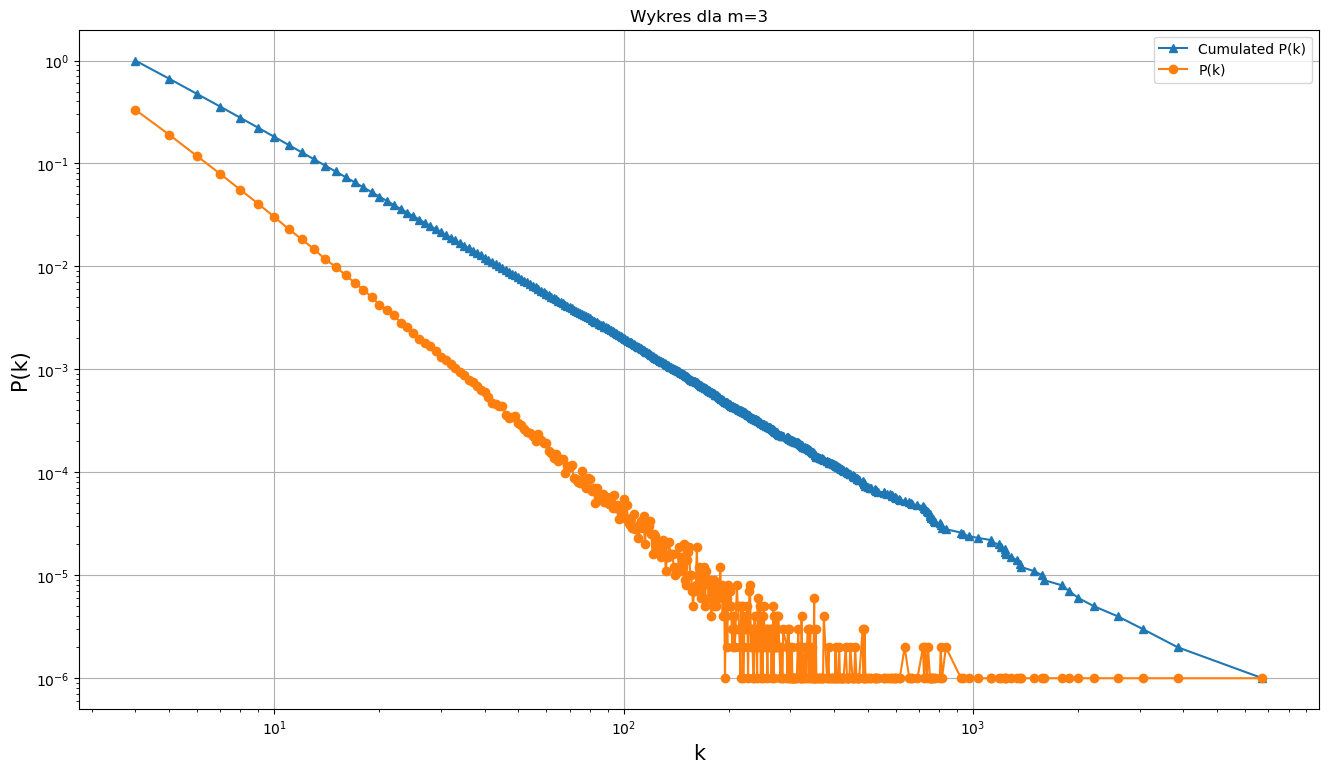

In [88]:
vals,counts=np.unique(node_list,return_counts=True)
vals,counts=np.unique(counts,return_counts=True)
prob=counts/np.sum(counts)
plt.figure(figsize=(16,9),dpi= 100)
plt.loglog(vals,np.cumsum(prob[::-1])[::-1],"^-",label="Cumulated P(k)")
plt.loglog(vals,prob,"o-",label="P(k)")
plt.legend()
plt.grid()
plt.xlabel("k",fontsize=15)
plt.ylabel("P(k)",fontsize=15)
plt.title(f"Wykres dla m={m}")